<a href="https://colab.research.google.com/github/eyaler/face_workshop/blob/master/notebooks/10_face_recognition_insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition InsightFace

In [1]:
!git clone https://github.com/eyaler/face_workshop


Cloning into 'face_workshop'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 159 (delta 8), reused 30 (delta 5), pack-reused 124
Receiving objects: 100% (159/159), 148.41 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!pip install mxnet
!pip install insightface

     |████████████████████████████████| 25.4MB 21.4MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for insightface: filename=insightface-0.1.5-cp36-none-any.whl size=16764 sha256=218ae99835d0f191f5667a317dc7d1f3c8d0f60b603fb72a39b63a30019308a8
  Stored in directory: /root/.cache/pip/wheels/11/b8/83/2bac12a833d66d58aa9705f5e7d94d2e9055f16f4698af0df7
Successfully built insightface


In [3]:
%cd face_workshop

/content/face_workshop


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
# put system imports here
import os
import sys
from os.path import join
from glob import glob
from pathlib import Path
import random
import time

# put pip/conda installed imports here
import numpy as np
import pandas as pd
from tqdm import tqdm
import imutils
import cv2 as cv
import matplotlib.pyplot as plt

# put local imports here
fp_app_root = join(Path(os.getcwd()).parent)
sys.path.append(fp_app_root)
from app.settings import app_cfg
from app.utils import file_utils, draw_utils, im_utils
from app.models.bbox import BBoxNorm

In [0]:
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
import mxnet
import insightface
from sklearn.metrics.pairwise import cosine_similarity


## Get face image

In [7]:
# download from https://generated.photos/
fp_dir_gan = join(app_cfg.DIR_IMAGES, 'janez_janzas')
fps_im = glob(join(fp_dir_gan, '*.jpg'))
print(len(fps_im))

9


In [8]:
fa = insightface.app.FaceAnalysis()

Model file is not found. Downloading.


100%|██████████| 107062/107062 [00:07<00:00, 13425.04KB/s]


Model file is not found. Downloading.


100%|██████████| 237710/237710 [00:16<00:00, 14322.17KB/s]


Model file is not found. Downloading.


100%|██████████| 987/987 [00:00<00:00, 1038.36KB/s]


In [9]:
fa.prepare(-1)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [10]:
fps_vector = []
face_vectors = []

for fp_im in tqdm(fps_im):
  im = cv.imread(fp_im)
  im = imutils.resize(im, width=360)
  face = fa.get(im)
  if len(face):
    face = face[0]
    face_vectors.append(face.normed_embedding)
    fps_vector.append(fp_im)

100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


## Query Image

In [0]:
fp_im = join(app_cfg.DIR_IMAGES, 'Janez_Jansa_id-card_01.jpg')
im_query = cv.imread(fp_im)
face_query = fa.get(im_query)[0]
vector_query = face_query.normed_embedding

In [12]:
n_results = 3
st = time.time()
sim = cosine_similarity([vector_query], face_vectors)[0]
print(time.time() - st)

0.0013992786407470703


In [13]:
match_idxs = np.argpartition(sim, -n_results)[-n_results:]
match_idxs = match_idxs[np.argsort(sim[match_idxs])]
match_idxs = match_idxs[::-1]

print(match_idxs)
for i in match_idxs:
  if sim[i] > 0.5:
    print(f'Found match! --> {Path(fps_vector[i]).name}')
  print(sim[i])

[4 7 0]
Found match! --> 300868340_640_2.jpg
0.90389574
0.10305449
0.085633546


In [0]:
#ims_match = [fp_im_hanks]
ims_match = [im_query] + [cv.imread(fps_vector[i]) for i in match_idxs]

In [0]:
montages = imutils.build_montages(ims_match, (400,400), (4,2))

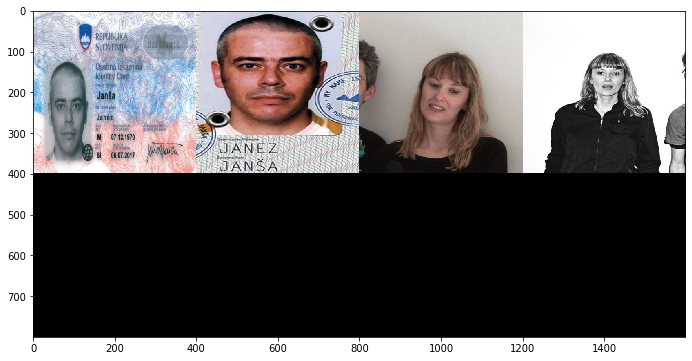

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(montages[0], cv.COLOR_BGR2RGB))